In [79]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

In [80]:
g = nx.Graph()
g

In [81]:
# Let me first load my homework used data

spamDF = pandas.read_csv('./SMSSpamCollection.csv')
spamDF[:3]

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [82]:
# Tokenize and normalize my text data

spamDF['tokenized_sents'] = spamDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
spamDF['normalized_sents'] = spamDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

In [83]:
spamDF[:3]

,target,text,tokenized_sents,normalized_sents
0,ham,"Go until jurong point, crazy.. Available only ...","[[Go, until, jurong, point, crazy], [Available...","[[jurong, point, crazy], [available, bugis, n,..."
1,ham,Ok lar... Joking wif u oni...,"[[Ok, lar], [Joking, wif, u, oni]]","[[okay, lar], [joke, wif, u, oni]]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[[Free, entry, in, 2, a, wkly, comp, to, win, ...","[[free, entry, wkly, comp, win, fa, cup, final..."


In [84]:
# Take a look at words that co-occur in the sentences

def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [85]:
# build a graph based on word cooccurences in the first 100 samples

g = wordCooccurrence(spamDF['normalized_sents'][:100].sum())

In [86]:
# Total number of vertices

len(g.nodes)

528

In [87]:
# Total number of edges

len(g.edges)

1453

In [88]:
# A part of the adjacency matrix of cleaned word by press releases

nx.to_numpy_matrix(g)[:10, :10]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [89]:
# save the graph and read it later

nx.write_graphml(g, './spam_words.graphml')

In [90]:
# Alternatively, we build graphs starting with a two-mode network. 
# Let's use the document-word frequency matrix.

In [91]:
def tokenize(text):
    tokenlist = lucem_illud.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist)
    return normalized

In [92]:
import sklearn.feature_extraction

In [93]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(spamDF['text'][:100])

In [94]:
senVects_incidence.shape

(100, 528)

In [95]:
# turn the incidence matrix into a network

g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [96]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 628
Number of edges: 789
Average degree:   2.5127


/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


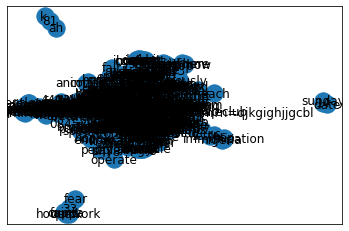

In [97]:
# plot the bipartite network with a quick spring layout

nx.draw_networkx(g_2mode)

In [98]:
# A two-mode network can be easily transformed into two one-mode network

def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [99]:
gDoc = contractNetwork(g_2mode, 'doc')

In [100]:
# first take a look at the document-to-document network

In [101]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 548
Average degree:  10.9600


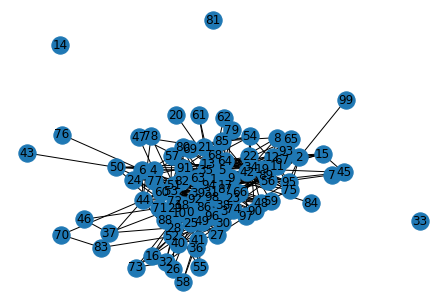

In [102]:
# visualization
# use edge weight to distinguish document distance (modeled as attraction)

layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

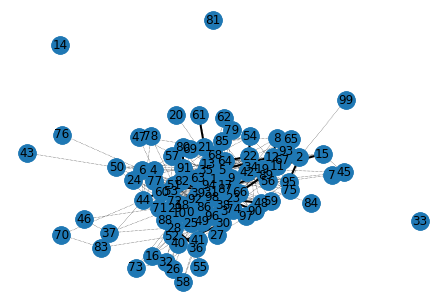

In [103]:
# draw the graph with high and low weight edges distinguished

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [104]:
print(len(spamDF.iloc[9]['text']),"words:","\n",spamDF.iloc[9]['text'].strip().replace('  ', '\n'))

# those documents with the most words are unsprisingly the most central in this simple document network.

154 words: 
 Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [105]:
print(len(spamDF.iloc[20]['text']),"words:","\n",spamDF.iloc[20]['text'].strip().replace('  ', '\n'))

41 words: 
 Is that seriously how you spell his name?


In [106]:
# Now let's look at the word-to-word network by documents.

gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 528
Number of edges: 3848
Average degree:  14.5758


In [107]:
# First reduce the number of words to a manageable size.
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.0272869022869022

In [108]:
# We are going to return to the sentence cooccurence graph, 
# as it suggests many more meaningful (more local) associations. 
# But without filtering, it is too large. Let's first drop all the edges with weight below 25, then drop all the isolates

g = wordCooccurrence(spamDF['normalized_sents'][:100].sum())
len(g)

528

In [109]:
#g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 25])

In [110]:
#g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first

In [111]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [112]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 405
Number of edges: 1316
Average degree:   6.4988


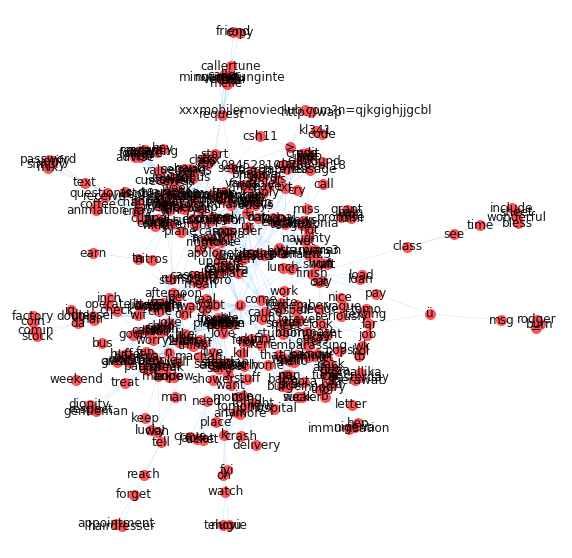

In [113]:
# A bit smaller now, Now, let's visualize it

layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [114]:
# introduce a concept of finding communities in graphs

from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))
c

[frozenset({'+',
            '10am-9pm',
            '2nd',
            'ac',
            'aco&entry41',
            'advise',
            'award',
            'bonus',
            'camcorder',
            'camera',
            'cash',
            'chance',
            'charge',
            'co',
            'collect',
            'colour',
            'complimentary',
            'confirm',
            'customer',
            'darling',
            'end',
            'entitle',
            'eurodisinc',
            'fair',
            'follow',
            'free',
            'gauti',
            'go',
            'guarantee',
            'hey',
            'i‘m',
            'jackpot',
            'late',
            'learn',
            'machan',
            'membership',
            'mob',
            'mobile',
            'month',
            'network',
            'nokia',
            'odi',
            'plane',
            'please',
            'prize',
            'r',
        

In [115]:
# remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score)
# this is just to demonstrate the different kinds of node dropping and graph changes we can do.

In [116]:
giant = nx.Graph(giant)
print(nx.info(giant))

# Note that for this case we get the same graph

Name: 
Type: Graph
Number of nodes: 405
Number of edges: 1316
Average degree:   6.4988


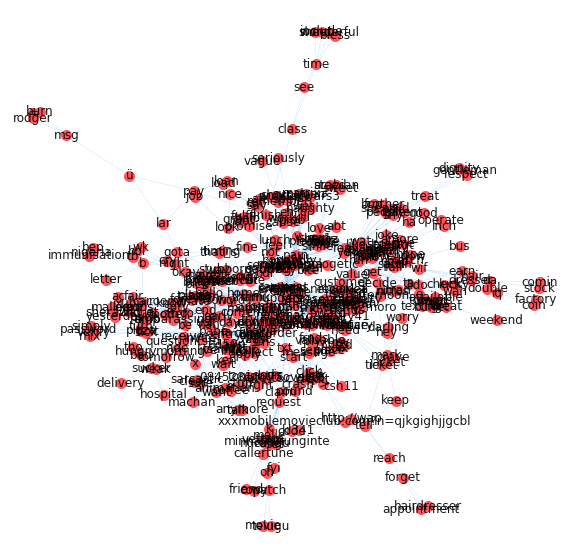

In [117]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [118]:
# we can find cliques, or completely connected sets of nodes
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

u, like, love, smile, pain, sum1, pleasure, pour, trouble, rain, becoz, hurt


In [119]:
# Now let's look at a subgraph of the network, 
# those nodes that are within 1 or 2 network steps of 'free'.

americanNeighbors = giant.neighbors('free')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 163
Average degree:   8.5789


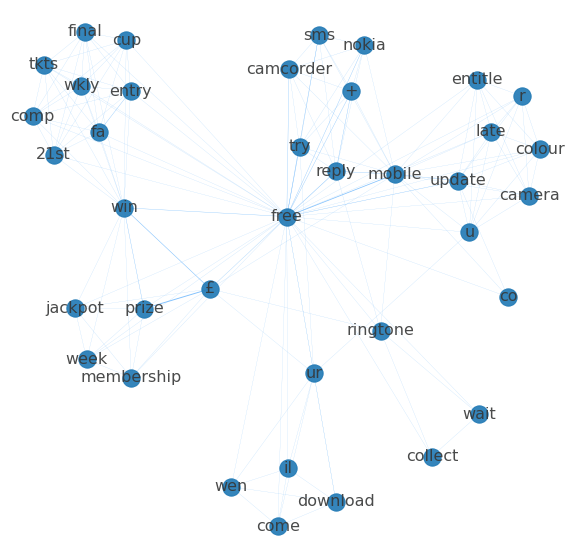

In [120]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# hmmm.... interesting. The result is pretty much intuitive
# the word "free" is indeed always connected closely with words like  "try",
# "win" and "reply", at least in my sense

In [121]:
americanNeighbors = gWord.neighbors('free')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [122]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: Graph
Number of nodes: 67
Number of edges: 194
Average degree:   5.7910


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

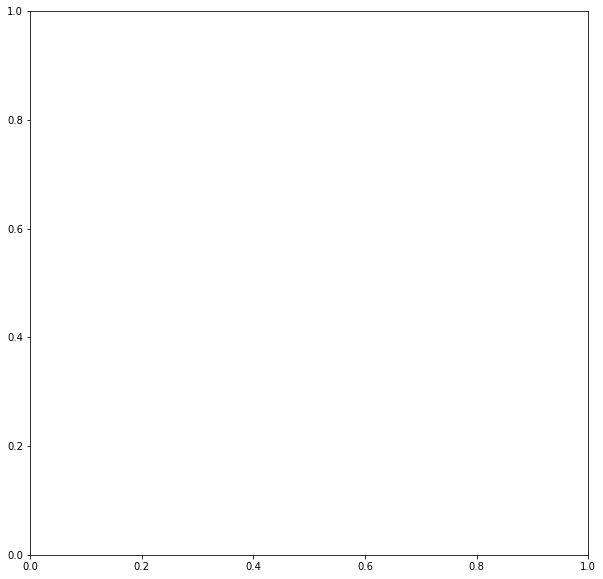

In [123]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 250, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 


# This reports error. No matter how I tune the parameter, the error would not disappear.
# So I will just leave it there

In [125]:
#  gain more insight into our semantic network through statistics that describe the positions of words within it.

In [126]:
#  We begin with measures of centrality
# The most straightforward is the notion of degree centrality

In [127]:
dcentralities = nx.degree_centrality(giant)

In [128]:
dcentralities['free']

0.09653465346534654

In [129]:
sorted(dcentralities.items(), reverse = True, key = lambda x:x[1])

# in my spam data set, simple words including u, money sign, free and simple action words are located in the center

[('u', 0.12623762376237624),
 ('£', 0.10643564356435643),
 ('free', 0.09653465346534654),
 ('like', 0.09653465346534654),
 ('get', 0.07673267326732673),
 ('be', 0.06435643564356436),
 ('ur', 0.06435643564356436),
 ('reply', 0.06435643564356436),
 ('yes', 0.06435643564356436),
 ('mobile', 0.0594059405940594),
 ('v', 0.05693069306930693),
 ('win', 0.05198019801980198),
 ('txt', 0.05198019801980198),
 ('late', 0.04950495049504951),
 ('customer', 0.04702970297029703),
 ('prize', 0.04702970297029703),
 ('+', 0.04455445544554455),
 ('try', 0.04455445544554455),
 ('n', 0.04207920792079208),
 ('know', 0.039603960396039604),
 ('way', 0.039603960396039604),
 ('home', 0.039603960396039604),
 ('love', 0.03712871287128713),
 ('month', 0.03712871287128713),
 ('thank', 0.03712871287128713),
 ('not', 0.03712871287128713),
 ('pain', 0.034653465346534656),
 ('okay', 0.034653465346534656),
 ('send', 0.034653465346534656),
 ('come', 0.03217821782178218),
 ('value', 0.03217821782178218),
 ('ringtone', 0.03

In [130]:
max(dcentralities.items(), key = lambda x : x[1])

# strightforward enough. u is always written in messages

('u', 0.12623762376237624)

/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


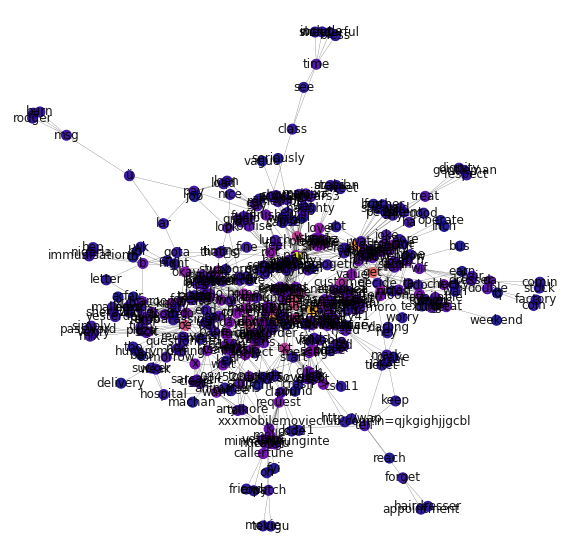

In [131]:
# We can color and size the nodes by betweenness centrality

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


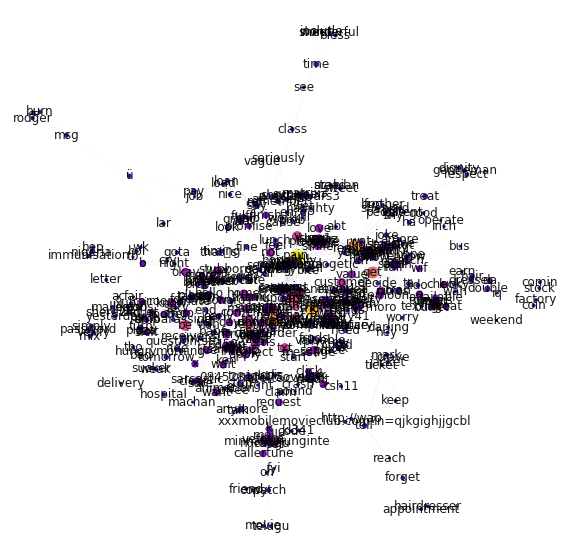

In [132]:
# Another way to visualize the graph involes the use of size to represent degree centrality and edge weight

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

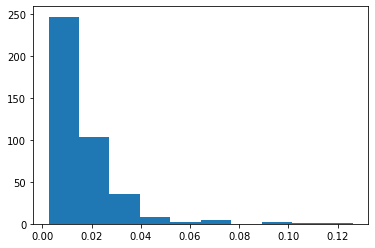

In [133]:
# The distrubution of degree centrality

plt.hist(list(dcentralities.values()))
plt.show()

In [134]:
# the top ten words in terms of degree

sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('u', 0.12623762376237624),
 ('£', 0.10643564356435643),
 ('free', 0.09653465346534654),
 ('like', 0.09653465346534654),
 ('get', 0.07673267326732673),
 ('be', 0.06435643564356436),
 ('ur', 0.06435643564356436),
 ('reply', 0.06435643564356436),
 ('yes', 0.06435643564356436),
 ('mobile', 0.0594059405940594)]

In [135]:
# the bottom ten words in terms of degree

sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

# interestingly, tb is one of the bottom ten words 

[('pound', 0.0024752475247524753),
 ('bus', 0.0024752475247524753),
 ('machan', 0.0024752475247524753),
 ('seriously', 0.0024752475247524753),
 ('fair', 0.0024752475247524753),
 ('vague', 0.0024752475247524753),
 ('delivery', 0.0024752475247524753),
 ('tb', 0.0024752475247524753),
 ('inch', 0.0024752475247524753),
 ('job', 0.0024752475247524753)]

In [136]:
# Consider another very different measure, which is betweenness centrality.

In [137]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [138]:
centralities['free']

# the number rises from 0.09 to 0.156

0.1566291450519353

In [139]:
max(centralities.items(), key = lambda x : x[1])

('u', 0.33733290399376176)

/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


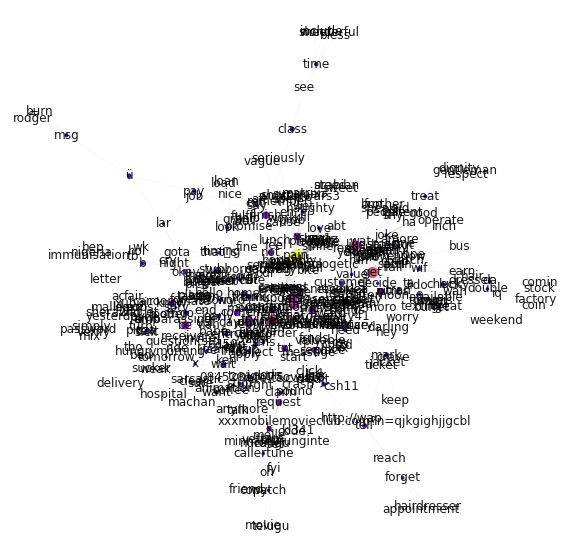

In [140]:
# color and size the nodes by betweenness centrality

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

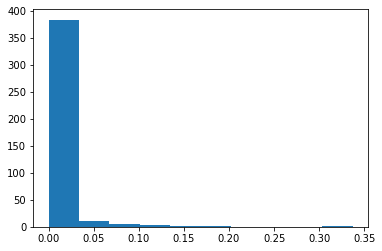

In [141]:
# The distrubution of betweenness centrality

plt.hist(list(centralities.values()))
plt.show()

In [142]:
# the top ten words in terms of betweenness

sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

# it is clear the top ten words do not change much 

[('u', 0.12623762376237624),
 ('£', 0.10643564356435643),
 ('free', 0.09653465346534654),
 ('like', 0.09653465346534654),
 ('get', 0.07673267326732673),
 ('be', 0.06435643564356436),
 ('ur', 0.06435643564356436),
 ('reply', 0.06435643564356436),
 ('yes', 0.06435643564356436),
 ('mobile', 0.0594059405940594)]

In [143]:
# What are words lower down?

sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('e', 0.027227722772277228),
 ('>', 0.027227722772277228),
 ('lt;#&gt', 0.027227722772277228),
 ('request', 0.027227722772277228),
 ('becoz', 0.027227722772277228),
 ('uk', 0.024752475247524754),
 ('wait', 0.024752475247524754),
 ('award', 0.024752475247524754),
 ('charge', 0.024752475247524754),
 ('callertune', 0.024752475247524754)]

In [144]:
# We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network

centralities = nx.closeness_centrality(giant)

/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


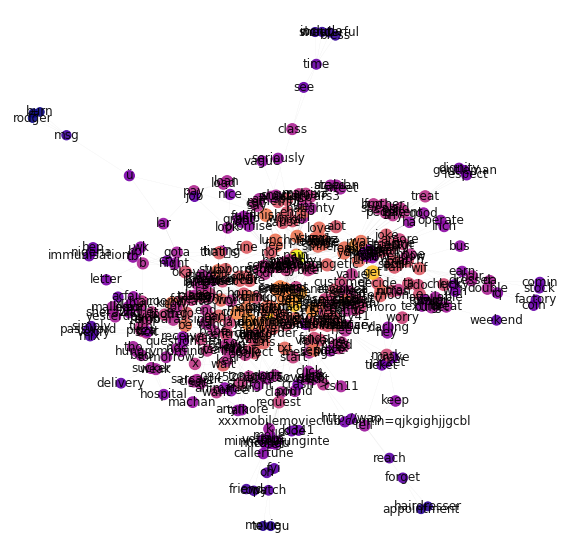

In [145]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

In [146]:
# Top and bottom

sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

# the second top ten word has been replaced by the word ur. 
# But in general, they change only in their order, but not the content 

[('u', 0.3918525703200776),
 ('ur', 0.36330935251798563),
 ('free', 0.36200716845878134),
 ('get', 0.35879218472468916),
 ('mobile', 0.3568904593639576),
 ('late', 0.33949579831932775),
 ('yes', 0.33582709891936824),
 ('like', 0.3338842975206612),
 ('try', 0.3284552845528455),
 ('£', 0.3271255060728745)]

In [148]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

# the bottom ten words are quite different 

[('wonderful', 0.16244471250502612),
 ('bless', 0.16244471250502612),
 ('include', 0.16244471250502612),
 ('telugu', 0.15725963409887114),
 ('movie', 0.15725963409887114),
 ('hairdresser', 0.15689320388349515),
 ('appointment', 0.15689320388349515),
 ('rodger', 0.14527148507731033),
 ('=', 0.14527148507731033),
 ('burn', 0.14527148507731033)]

In [149]:
# eignvector centrality

In [150]:
centralities = nx.eigenvector_centrality(giant)

/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/raychanan/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


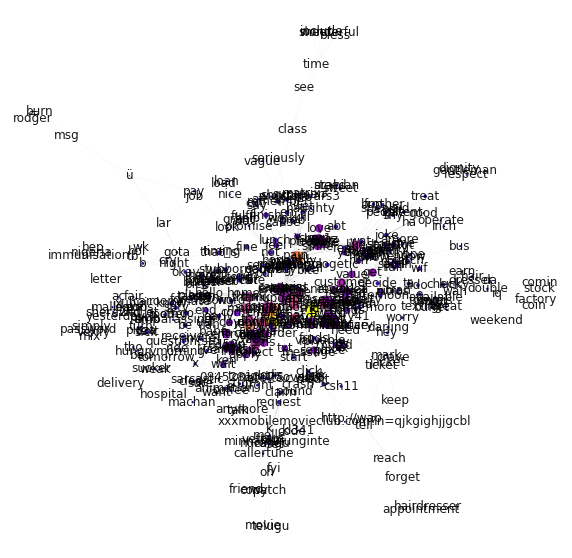

In [151]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

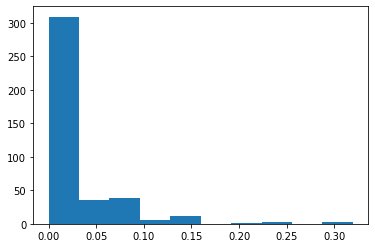

In [152]:
plt.hist(list(centralities.values()))
plt.show()

# the colors reveal a much more graduate distribution here

In [153]:
# Top and bottom

sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

# no matter which method I used, the results basically keep the same 

[('£', 0.3194246184004336),
 ('free', 0.29731463175201833),
 ('mobile', 0.24022264299861815),
 ('u', 0.22805267879217678),
 ('reply', 0.21492398025261314),
 ('yes', 0.15731030087881462),
 ('ringtone', 0.15355407349569342),
 ('win', 0.15097802677419897),
 ('ur', 0.14503032063819202),
 ('month', 0.14248606002996472)]

In [154]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

# the result is similar to the last method used above

[('wonderful', 1.5332672801592364e-05),
 ('bless', 1.5332672801592364e-05),
 ('include', 1.5332672801592364e-05),
 ('telugu', 8.105002141368732e-06),
 ('movie', 8.105002141368732e-06),
 ('hairdresser', 3.7568831500711047e-06),
 ('appointment', 3.7568831500711047e-06),
 ('rodger', 1.9038345582124127e-06),
 ('=', 1.9038345582124124e-06),
 ('burn', 1.9038345582124124e-06)]

In [155]:
# We can now filter our network by a centrality measure

In [157]:
# Let's define a function and experiment with it


def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [227]:
giant_filtered30 = filterWords(giant, minWeight=1, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 55
Average degree:   4.4000


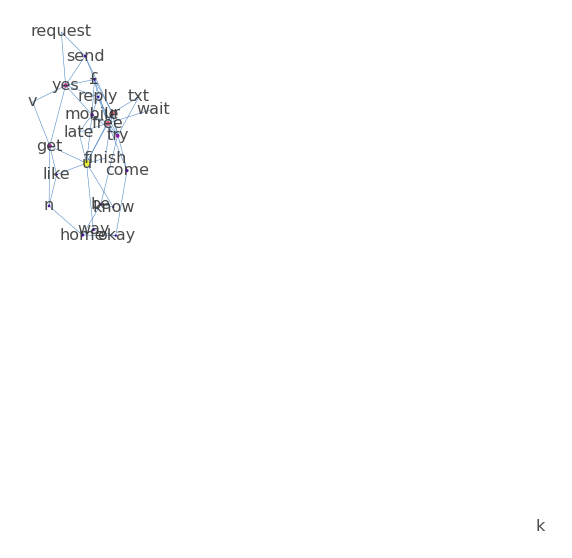

In [228]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / 1 for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / 1 * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [160]:
# can also look at global statistics, like the density of a network

nx.density(giant)

# the density of the netword is not very high

0.01608605304974942

In [161]:
# can also calculate the average degree per node

np.mean([v for w,v in nx.degree(giant)])

# however, the average degree per node is slightly higher than i have expected

6.498765432098765

In [162]:
# Calculates the average distance between any two nodes in the network

nx.diameter(giant)

# so I think, according to the result, the netword is relatively sparse
# they are not closely connected to each other

10

In [177]:
# 4  POS based networks
# look at links between specific parts of speech within a network

In [190]:
# look at nouns co-occurring in sentences

tweetDF = pandas.read_csv('./Corona_NLP_test.csv', index_col = 0)

redditTopScores = tweetDF[:1000]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

<ipython-input-190-3a6f7bfef95d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])


,ScreenName,Location,TweetAt,text,Sentiment,sentences
999,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,"[[TRENDING], [New, Yorkers, encounter, empty, ..."
998,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,"[[When, I, could, n't, find, hand, sanitizer, ..."
997,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,"[[Find, out, how, you, can, protect, yourself,..."


In [191]:
# normalize the tokens through stemming

redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

<ipython-input-191-37d4663edba3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])


In [192]:
# revisit spacy and use it's english language model.

In [193]:
import spacy

In [194]:
nlp = spacy.load('en')

In [195]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [196]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [197]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 1630
Number of edges: 9318
Average degree:  11.4331


In [200]:
# As my data is  too large, I would remove some of them 

gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 145
Average degree:  16.1111
Name: 
Type: Graph
Number of nodes: 18
Number of edges: 100
Average degree:  11.1111


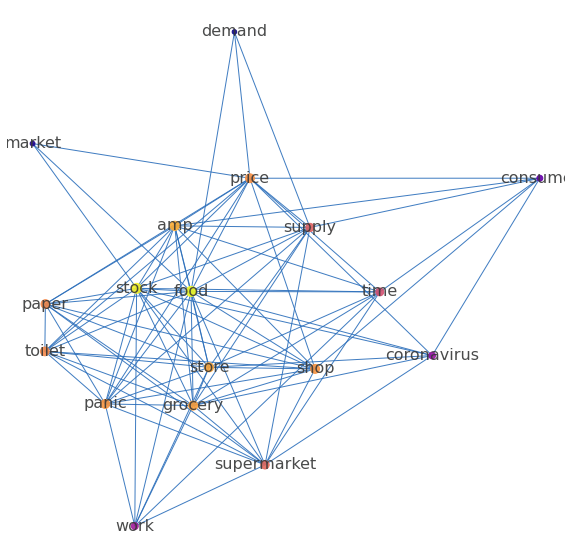

In [202]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )


# very inspiring result and it coincides with our intuition.

# the word coronovirus is connected with shopping-related words and people 
# do care about the time

In [203]:
# we want to look at noun-verb pairs

gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

In [204]:
# gNV has co-occurrences between nouns and nouns as well as between verbs and verbs. 
# Let's remove these and make it purely about noun and verb combinations

print(nx.info(gNV))
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 1780
Number of edges: 12467
Average degree:  14.0079
Name: 
Type: Graph
Number of nodes: 1780
Number of edges: 3154
Average degree:   3.5438


In [205]:
# Dropping low weight edges and low degree

gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [206]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 36
Average degree:   4.5000


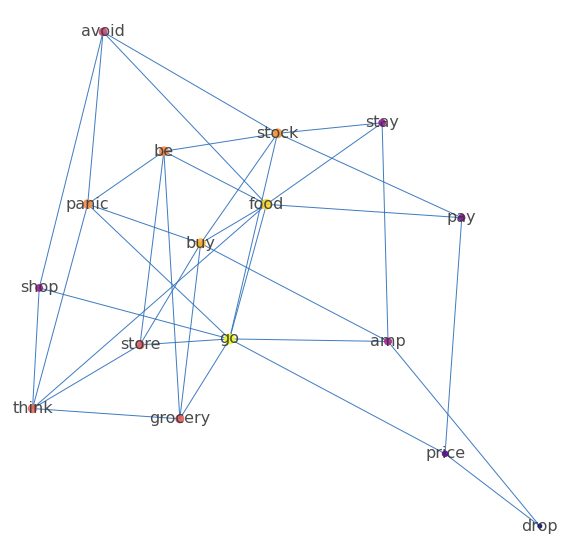

In [208]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 


# haha, besides purchasing necessary food, people also want to gain some money but betting on their stocks 

In [209]:
# create an "ego network" surrounding a single (important) word

g_i = gNV.subgraph(['buy'] + list(gNV.neighbors('buy')))

In [210]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 6
Average degree:   1.7143


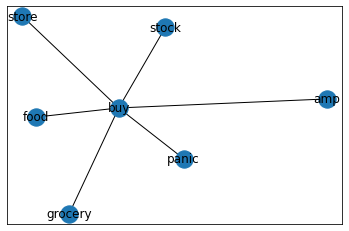

In [211]:
nx.draw_networkx(g_i)

# the result is quite the same as what it was in the above
# but this time, it's much clearer in this kind of visualization

In [230]:
# Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops

storyNeighbors = gNV.neighbors('food')
set(storyNeighbors)

{'avoid', 'be', 'buy', 'go', 'pay', 'stay', 'think'}

In [231]:
storyNeighbors = set(gNV.neighbors('food'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [232]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 15
Number of edges: 34
Average degree:   4.5333


In [233]:
# interrogate it intelligently by computing some statistics
# Degree centrality

sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('go', 0.5714285714285714),
 ('food', 0.5),
 ('stock', 0.42857142857142855),
 ('buy', 0.42857142857142855),
 ('think', 0.3571428571428571),
 ('be', 0.3571428571428571),
 ('panic', 0.3571428571428571),
 ('grocery', 0.2857142857142857),
 ('store', 0.2857142857142857),
 ('avoid', 0.2857142857142857)]

In [234]:
# eigenvector centrality

sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('go', 0.37799351797895886),
 ('food', 0.35655828343655444),
 ('buy', 0.3228877588870058),
 ('stock', 0.3044204319081876),
 ('panic', 0.2933450674324556),
 ('be', 0.2886453528442608),
 ('think', 0.26227761994580695),
 ('grocery', 0.24884465659961313),
 ('store', 0.24884465659961313),
 ('avoid', 0.2238577434259123)]

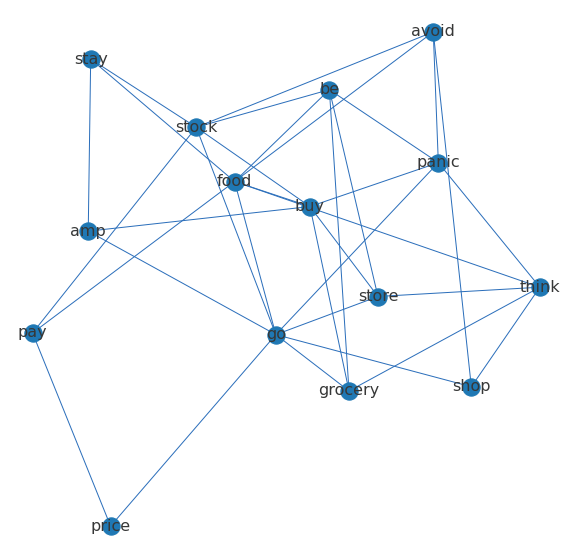

In [235]:
# plot

layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [236]:
# Create a noun-adjective network

gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 532
Number of edges: 2002
Average degree:   7.5263


In [237]:
# By filtering by a centrality measure we can get a 
# more 'central' set of nodes instead of just the most connected.

gNJ_filtered200 = filterWords(gNJ, minWeight=1, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 79
Average degree:   6.3200


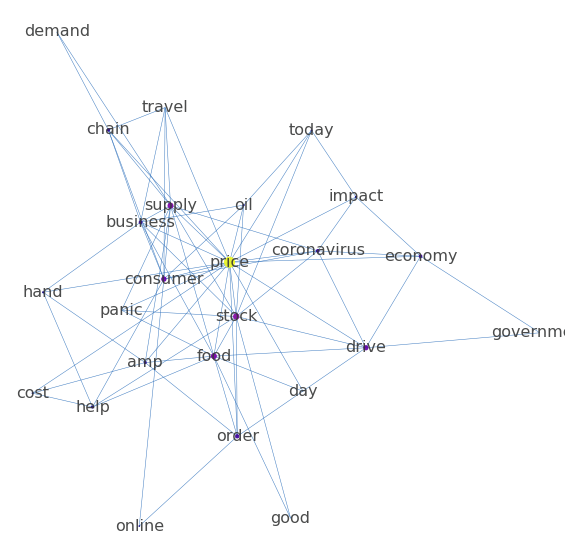

In [238]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In [229]:
storyNeighborsPlus2 = set(storyNeighborsPlus1)
storyNeighbors

{'amp', 'food', 'grocery', 'panic', 'stock', 'store'}

In [239]:
# in the above, we only did up to two links away above.
# Graph some word-centered "ego-networks" with words three links away 


storyNeighbors = gNV.neighbors('stay')
set(storyNeighbors)

storyNeighbors = set(gNV.neighbors('stay'))
storyNeighborsPlus2 = set(storyNeighborsPlus1)
for n in storyNeighbors:
    storyNeighborsPlus2 |= set(gNV.neighbors(n))

In [240]:
gNV_story = gNV.subgraph(storyNeighborsPlus2)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 16
Number of edges: 36
Average degree:   4.5000


In [241]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('go', 0.5333333333333333),
 ('food', 0.4666666666666667),
 ('stock', 0.4),
 ('buy', 0.4),
 ('think', 0.3333333333333333),
 ('be', 0.3333333333333333),
 ('panic', 0.3333333333333333),
 ('amp', 0.26666666666666666),
 ('grocery', 0.26666666666666666),
 ('store', 0.26666666666666666)]

In [242]:
# eigenvector centrality

sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('go', 0.3789733126064112),
 ('food', 0.3541341455634287),
 ('buy', 0.32197723356220165),
 ('stock', 0.30274786748477056),
 ('panic', 0.29074227240056877),
 ('be', 0.2855798399950343),
 ('think', 0.25934975275940336),
 ('grocery', 0.24685254530549003),
 ('store', 0.24685254530549003),
 ('avoid', 0.2215141787009668)]

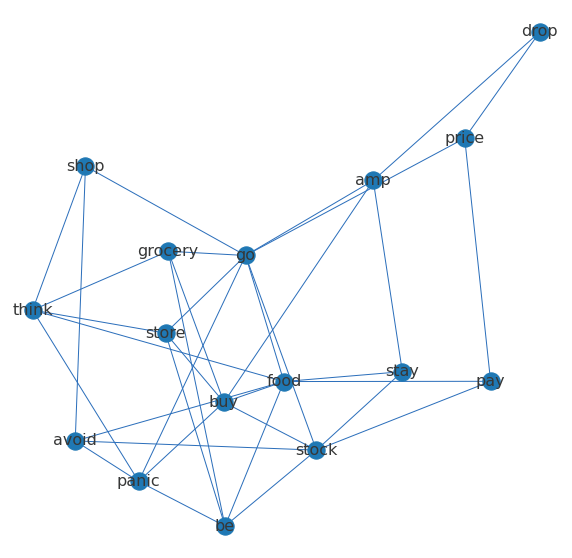

In [243]:
# plot it

layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In [244]:
# 4.2  Creating networks of agents from corpora


In [246]:
corpora_address = "/Users/raychanan/Downloads/SOAP"

In [247]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [248]:
import zipfile

In [249]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [250]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [252]:
import pandas as pd

In [253]:
soap_dict = {}

In [254]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [255]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [256]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [257]:
soap_df[:3] # DIY

,Soap Name,Tokenized Texts


In [258]:
i = 0

In [259]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [260]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


In [261]:
# I conducted my basic analysis on that the second soap 

In [262]:
dool = soap_df['Tokenized Texts'][1]

In [263]:
' '.join(dool[0:1500])

"@!Katie Okay I know these words are long overdue and I know they could never erase all of the pain and the heartache that I 've caused each of you but I need to say them And hopefully someday somehow you will find it in your hearts to accept them because I 'm sorry for everything Margo I know that you only wanted to be my big sister help me be the best person that I could be and all I ever showed you was grief Craig you believed in me when no one else would and I showed you my gratitude by acting like a selfish spoiled brat Lily and Holden I almost cost you your marriage And last but definitely not least Simon I only wanted to make you happy and I let a bird eat your diamond for breakfast and now it 's gone for good and I 'm sorry @!Cooley Now do n't you give up on that diamond little girl Ole Cooley 's gon na of it till I find that bird and then I 'm gon na rip that rock right outta his beak or his gullet if that 's what I have to @!Henry Forgive me if I do n't pitch in but I draw th

In [264]:
# every '@!' is followed by some useeful information. 
# Let us do a quick check of how many characters exist here, and how many times they speak.

In [265]:
characters = {}

In [266]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [267]:
len(characters)

801

In [268]:
# Let us maybe only look for characters with a high number of appearances

In [269]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Katie 3571
Henry 2278
Emily 2499
Craig 3385
Margo 2638
Jack 4414
Paul 3220
Carly 4873
Barbara 2096
Lily 3147
Holden 2232
Alison 2729
Dusty 2920


In [270]:
# create a graph where each character who appears over 2000 times is a node, 
# and each time they talk to each other, we add one to their weight
# We should also store all the things these chracters say: that's useful information.


In [271]:
# now iterate through the tokens in a manner where we can capture this information

In [272]:
actor_network = nx.Graph()

In [273]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [274]:
len(actor_network.nodes.data())

13

In [275]:
actor_network.nodes.data()

NodeDataView({'Katie': {'lines_spoken': 3571, 'words': []}, 'Henry': {'lines_spoken': 2278, 'words': []}, 'Emily': {'lines_spoken': 2499, 'words': []}, 'Craig': {'lines_spoken': 3385, 'words': []}, 'Margo': {'lines_spoken': 2638, 'words': []}, 'Jack': {'lines_spoken': 4414, 'words': []}, 'Paul': {'lines_spoken': 3220, 'words': []}, 'Carly': {'lines_spoken': 4873, 'words': []}, 'Barbara': {'lines_spoken': 2096, 'words': []}, 'Lily': {'lines_spoken': 3147, 'words': []}, 'Holden': {'lines_spoken': 2232, 'words': []}, 'Alison': {'lines_spoken': 2729, 'words': []}, 'Dusty': {'lines_spoken': 2920, 'words': []}})

In [276]:
actor_network.nodes['Carly']['lines_spoken']

4873

In [277]:
i = 0

In [278]:
# create the graph

for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

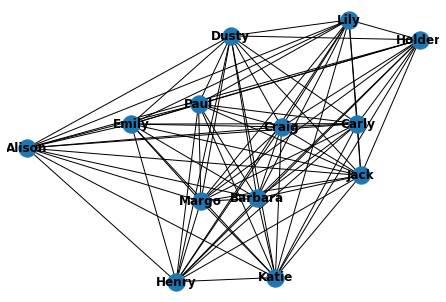

In [279]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [280]:
import seaborn as sns

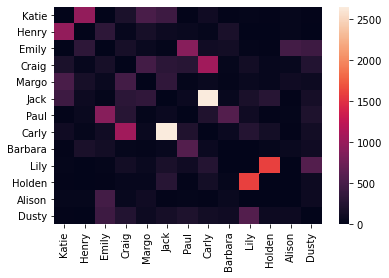

In [281]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [282]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [283]:
c

[frozenset({'Alison',
            'Barbara',
            'Carly',
            'Craig',
            'Dusty',
            'Emily',
            'Henry',
            'Holden',
            'Jack',
            'Katie',
            'Lily',
            'Margo',
            'Paul'})]

In [284]:
# as we can see with our heatmap, not everyone talks to everyone an equal amount. 
# How about we only keep our "important" ties, where people are talking to each other a lot?

In [285]:
smaller_actor_network = nx.Graph()

In [286]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


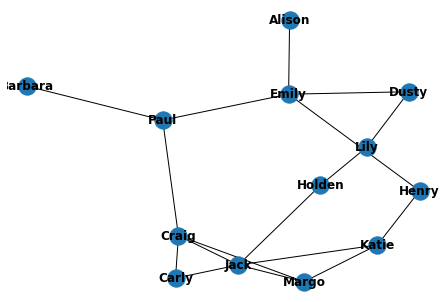

In [287]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

In [288]:
# now, the connection is much simpler than before.
# according to the result, jack really likes to talk!

In [289]:
# see what our centrality measures look like, as well as communities

In [290]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [291]:
c

[frozenset({'Alison',
            'Barbara',
            'Carly',
            'Craig',
            'Dusty',
            'Emily',
            'Henry',
            'Holden',
            'Jack',
            'Katie',
            'Lily',
            'Margo',
            'Paul'})]

In [292]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [293]:
dcentralities['Jack'], dcentralities['Lily']

# Jack is much more central than Lily

(0.41666666666666663, 0.16666666666666666)

In [294]:
import nltk

In [295]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [296]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud.normalizeTokens(character_words))

In [297]:
L = []

In [298]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

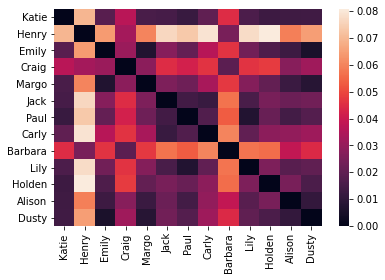

In [299]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

# we can se that Jack and Carky talk to each other very often
# Lily likes to talk with Paul

In [300]:
# 5.0.1  First let's look at the output of their analysis

In [310]:
# please note in this particular example, I would remain what it was,
# because the data given in the USpresident dataset seems not enough
example_name = '12-angry-men'

In [311]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [313]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()

In [314]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

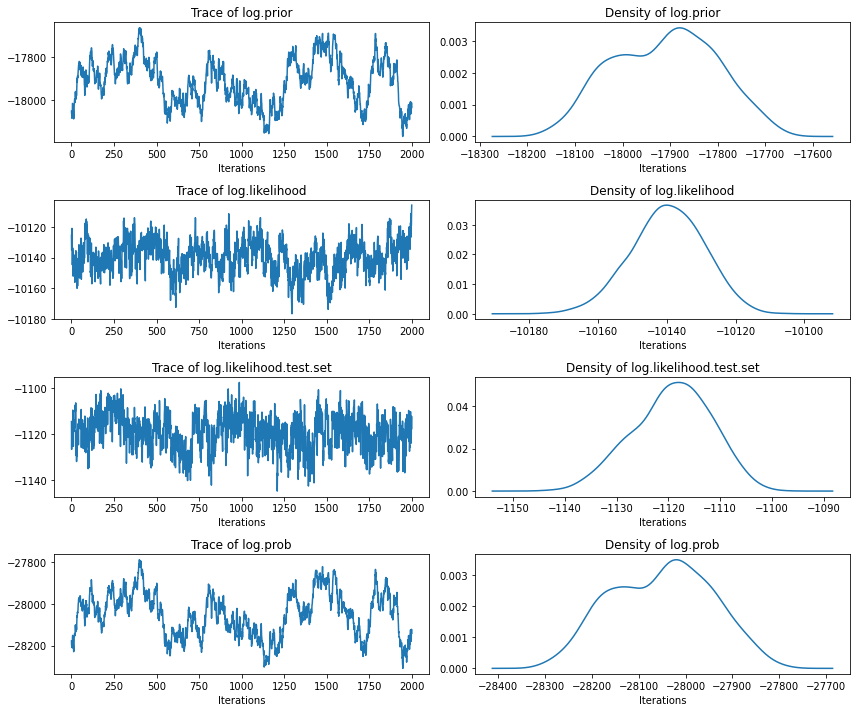

In [315]:
# Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

In [316]:
# Plot the influence matrix between participants

In [317]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [319]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


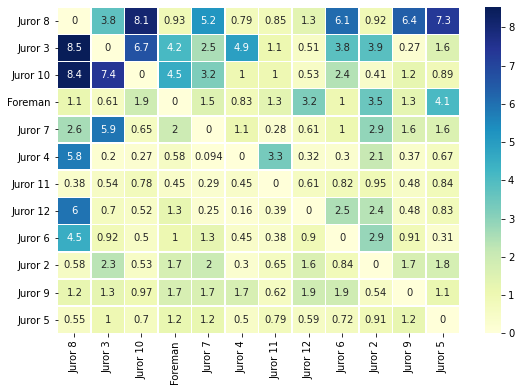

In [321]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
plt.show()

SD of influence matrix (row=from, col=to)


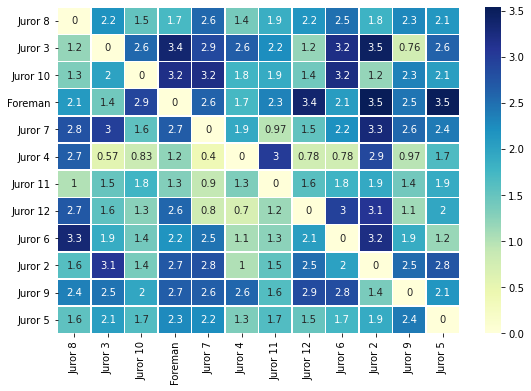

In [322]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
plt.show()

In [323]:
# Barplot of total influences sent/received



In [324]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

		Total linguistic influence sent/received 


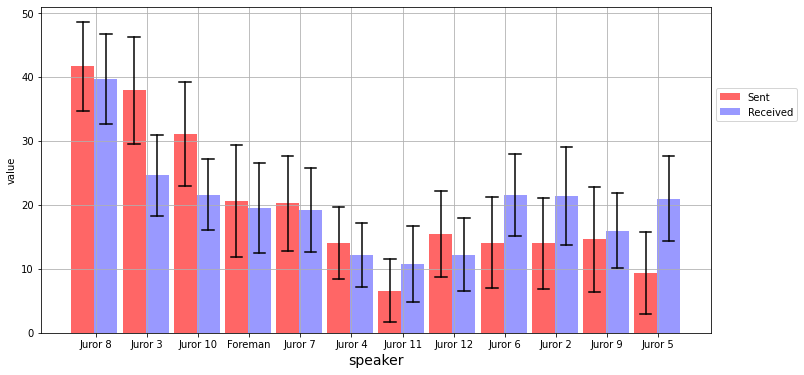

In [325]:
# Total influence

print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

In [326]:
# visualize any of the influence matrices above

In [328]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [329]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


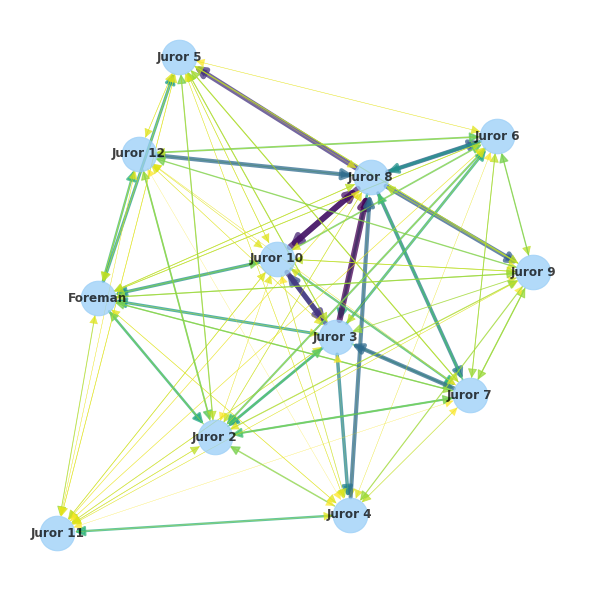

In [330]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


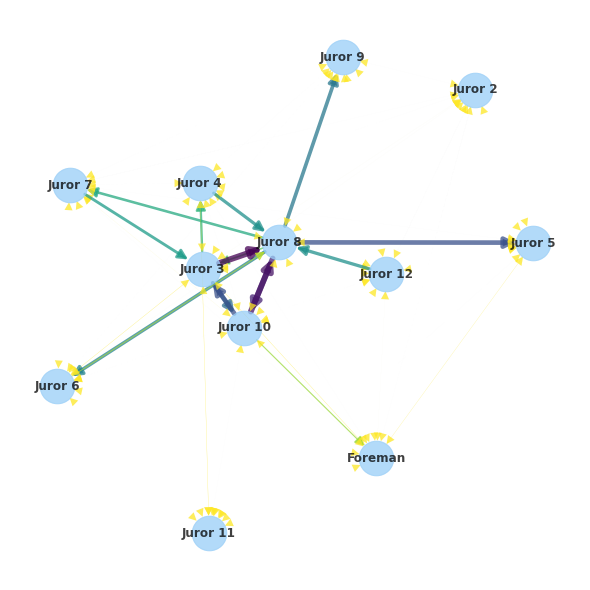

In [331]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


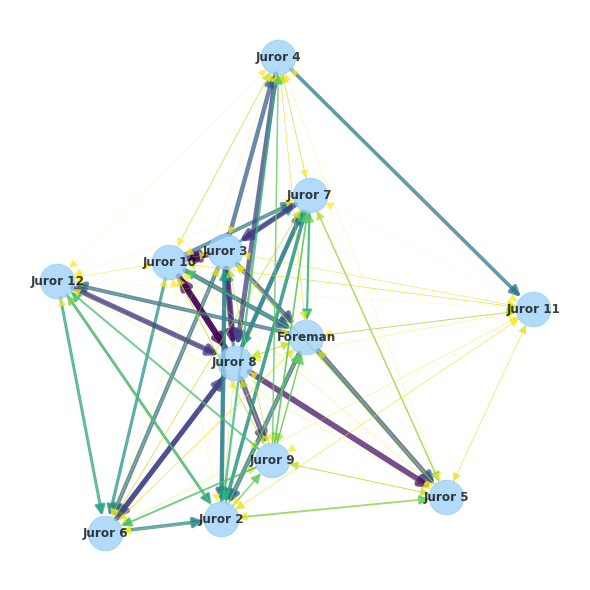

In [332]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [333]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

In [334]:
# create my own simulation

script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['columbia','uchicago','penn','NYU','UCLA','UCB','UBC','LSE','UCL','Imperial']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,UCLA,"[fkli, glel, baje, giil, jibk, skba, iifa, ide...",0.055676,1.896290
1,NYU,"[aadk, sjss, elie, agfj, dkck, ikae, icei, dll...",2.265302,3.598648


In [336]:
# Transform data into TalkbankXML format

output_fname = 'USuniversity.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USuniversity/USuniversity.xml


0

In [ ]:
# Run Bayesian Echo Chamber to get estimation

Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)